##Homework 4##
Javier Mencia

## Part I##

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


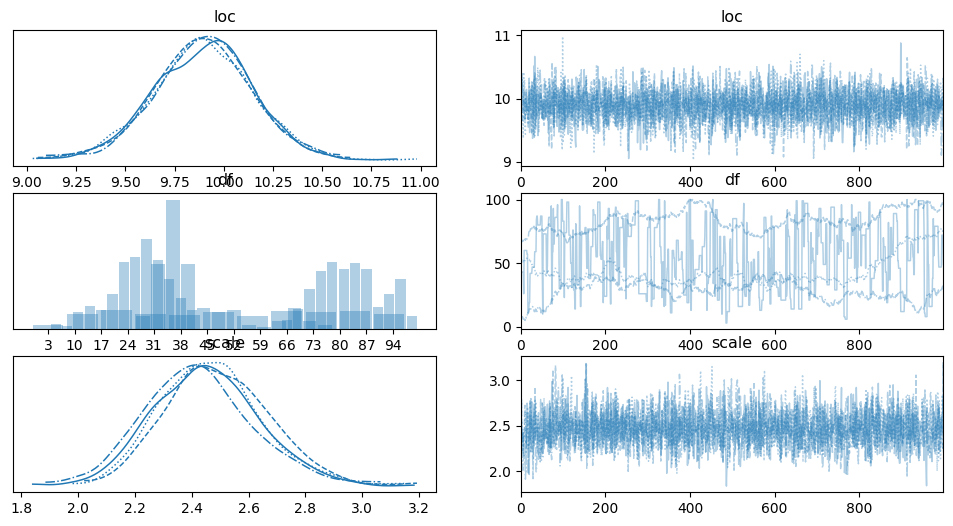

In [32]:
import pymc as pm
from scipy import stats; import numpy as np; import matplotlib.pyplot as plt


# Data
n, loc_true, scale_true, df_true = 100, 10, 2, 15
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

# Model
with pm.Model() as t_norm_half_normal_model:
    # Priors
    loc = pm.Normal('loc', mu=0, sigma=10)
    scale = pm.HalfNormal('scale', sigma=5)
    df = pm.DiscreteUniform('df', lower=1, upper=100)

    # Likelihood
    likelihood = pm.StudentT('likelihood', nu=df, mu=loc, sigma=scale, observed=x)

    # Sample using HMC
    trace = pm.sample(1000, tune=1000, chains=4)  # Adjust the number of samples and tuning steps as needed

# Plot trace
posteriors = az.convert_to_inference_data(trace)
axes = az.plot_trace(posteriors)
plt.show()


The sample size needed for reliable inference regarding the df parameter (ν) depends on achieving convergence and obtaining a sufficiently large number of effectively independent samples, i.e. the effective sample size. A higher sample size contributes to more robust and precise inferences.
The trace plot visually assesses the chain's convergence and mixing, ensuring it explores a broad range of values without exhibiting clear patterns or trends. The autocorrelation plot provides insights into the correlation structure within the chain, with faster decay indicating better mixing.

##Part II##

In [33]:
# Effective Sample Sizes
ess_summary = pm.summary(trace)
print("Effective Sample Sizes:")
print(ess_summary)


Effective Sample Sizes:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
loc     9.894   0.248   9.421   10.357      0.004    0.003    3519.0   
df     52.565  25.807  18.000   99.000     10.373    7.761       8.0   
scale   2.460   0.187   2.105    2.800      0.006    0.004     816.0   

       ess_tail  r_hat  
loc      2811.0   1.00  
df         79.0   1.51  
scale    1532.0   1.01  


Here we can see the effective sample size for loc is slightly lower than 4000, which implies that the effective sample size is almost a half of our true sample size, this seems a bit low

For chain convergence, we see that the four chains have similar distributions in the plot in part i, which indicates that they may converge

In [37]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Data
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

# Centered model
with pm.Model() as Centered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

    SEED = [20100420, 20134234]
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

# Non-Centered model
with pm.Model() as NonCentered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED, return_inferencedata=True, idata_kwargs={"log_likelihood": True})


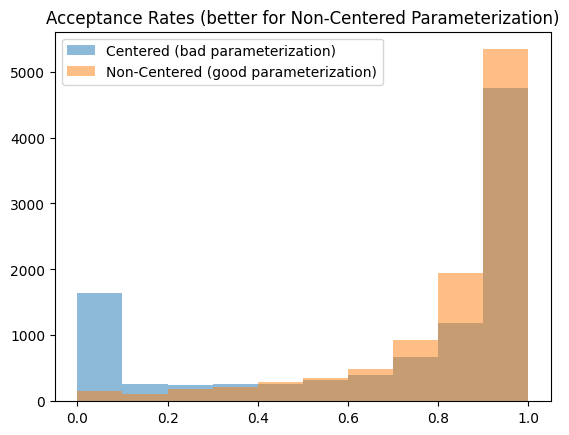

In [38]:
import matplotlib.pyplot as plt

# Plotting the Metropolis-Hastings Acceptance Rates
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5, label='Centered (bad parameterization)')
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5, label='Non-Centered (good parameterization)')
plt.title('Acceptance Rates (better for Non-Centered Parameterization)')
plt.legend()
plt.show()


In [39]:
import pandas as pd

# Print Effective Sample Sizes
ess_df = pd.concat([
    pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
                  'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
    pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
                  'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})
])

print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency):")
print(ess_df)


Effective Sample Sizes (function of Markov Chain autocorrelation dependency):
          Centered  Non-Centered
mu           623.0       11120.0
tau          129.0        5121.0
theta[0]     538.0       10859.0
theta[1]     978.0       11965.0
theta[2]    1575.0       11071.0
theta[3]     965.0       12523.0
theta[4]    1673.0       11294.0
theta[5]    1769.0       10616.0
theta[6]     415.0       11073.0
theta[7]    1248.0       11415.0


In [40]:
# Print information about divergences
print("Number of Divergences (Centered):", np.sum(fit_C.sample_stats.diverging))
print("Number of Divergences (Non-Centered):", np.sum(fit_NC.sample_stats.diverging))


Number of Divergences (Centered): <xarray.DataArray 'diverging' ()>
array(354)
Number of Divergences (Non-Centered): <xarray.DataArray 'diverging' ()>
array(8)


Here we see that the number of chains diverging, we have 4 chains of 6000 samples and only 354 diverge in the centered parameterization of the model and 8 in the non-centered one, these are both low numbers, which might indicate that we do not have a problem with divergence.

The "non-centered" parameterization is favored in HMC because it reduces the curvature of the energy function, leading to improved exploration of the parameter space, higher acceptance rates, and better convergence properties compared to the "centered" parameterization.

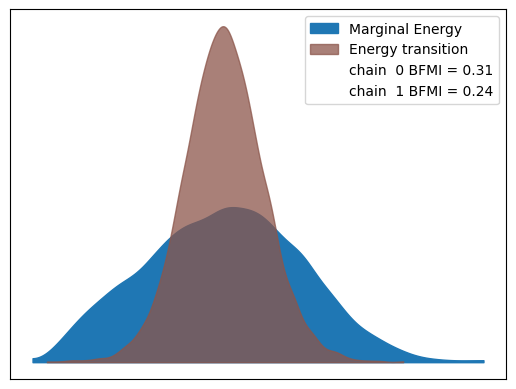

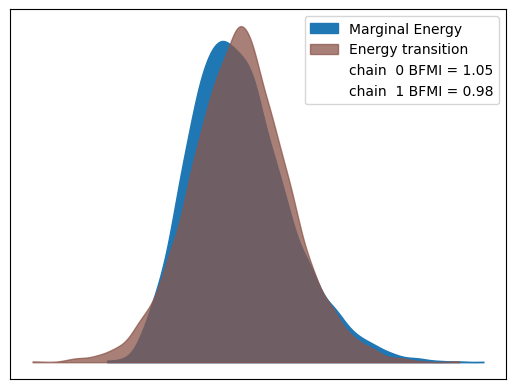

In [41]:
import arviz as az

# Plotting energy diagnostics for the centered and non-centered models
az.plot_energy(fit_C);
az.plot_energy(fit_NC);


The energy distribution plot for the "non-centered" model (fit_NC) appears more aligned with the reference line, this suggests that the HMC algorithm is proposing energy values that better match the empirical distribution of generated samples.